# cargar los datos 

In [101]:
# Importamos las librerías necesarias
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer


# Cargamos los datos
valoraciones = pd.read_json('data/web_reviews.json')

# Exploración de los datos

In [102]:
# Visualizamos las primeras filas del dataset
print("Primeras filas del dataset:")
print(valoraciones.head())

# Revisamos la estructura de las columnas y el tipo de datos
print("\nInformación del dataset:")
print(valoraciones.info())

# Calculamos estadísticas descriptivas para la columna 'overall'
print("\nEstadísticas descriptivas de la calificación 'overall':")
print(valoraciones['overall'].describe())

# Revisión de valores únicos y su distribución en 'overall'
print("\nDistribución de calificaciones (overall):")
print(valoraciones['overall'].value_counts())

# Análisis de la longitud de los textos en 'reviewText' para entender el contenido
valoraciones['review_length'] = valoraciones['reviewText'].apply(len)
print("\nLongitud promedio de las reseñas:")
print(valoraciones['review_length'].mean())

Primeras filas del dataset:
       reviewerID        asin  \
0  A2IBPI20UZIR0U  1384719342   
1  A14VAT5EAX3D9S  1384719342   
2  A195EZSQDW3E21  1384719342   
3  A2C00NNG1ZQQG2  1384719342   
4   A94QU4C90B1AX  1384719342   

                                       reviewerName   helpful  \
0  cassandra tu "Yeah, well, that's just like, u...    [0, 0]   
1                                              Jake  [13, 14]   
2                      Rick Bennette "Rick Bennette    [1, 1]   
3                          RustyBill "Sunday Rocker    [0, 0]   
4                                     SEAN MASLANKA    [0, 0]   

                                          reviewText  overall  \
0  Not much to write about here, but it does exac...        5   
1  The product does exactly as it should and is q...        5   
2  The primary job of this device is to block the...        5   
3  Nice windscreen protects my MXL mic and preven...        5   
4  This pop filter is great. It looks and perform...     

## entrenamiento 

In [103]:
# Eliminación de valores nulos en 'overall' y 'reviewText'
valoraciones = valoraciones.dropna(subset=['overall', 'reviewText'])

# Convertir 'overall' en categorías: 1-2 = negativa, 3 = neutral, 4-5 = positiva
def categorize_rating(rating):
    if rating <= 2:
        return "negativa"
    elif rating == 3:
        return "neutral"
    else:
        return "positiva"

valoraciones['sentimiento'] = valoraciones['overall'].apply(categorize_rating)

# Definimos el objetivo (target) y la característica (feature)
y = valoraciones['sentimiento']

# Convertir el texto de 'reviewText' en características numéricas usando TF-IDF
tfidf = TfidfVectorizer(max_features=100)
X_text = tfidf.fit_transform(valoraciones['reviewText']).toarray()

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_text, y, test_size=0.2, random_state=0)

# Crear el modelo de clasificación
model = RandomForestClassifier(n_estimators=100, random_state=0)

# Entrenar el modelo
model.fit(X_train, y_train)

# Realizar predicciones
predictions = model.predict(X_test)

# Evaluar el modelo con accuracy
accuracy = accuracy_score(y_test, predictions)
print(f"\nAccuracy: {accuracy}")

# También se puede calcular el MAE como referencia
mae = mean_absolute_error(y_test.map({'negativa': 0, 'neutral': 1, 'positiva': 2}), 
                          pd.Series(predictions).map({'negativa': 0, 'neutral': 1, 'positiva': 2}))
print(f"\nError absoluto medio (MAE) para las categorías: {mae}")


Accuracy: 0.8714076960545543

Error absoluto medio (MAE) para las categorías: 0.19581100828056502


## Tratamiento de valores faltantes

In [104]:
# Verificar valores faltantes en todas las características del DataFrame 'valoraciones'
print("\nValores faltantes en cada característica:")
print(valoraciones.isnull().sum())


Valores faltantes en cada característica:
reviewerID        0
asin              0
reviewerName      0
helpful           0
reviewText        0
overall           0
summary           0
unixReviewTime    0
reviewTime        0
instrumentType    0
review_length     0
sentimiento       0
dtype: int64


## Imputación

In [105]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_absolute_error
import pandas as pd

# Convertir el texto de 'reviewText' en características numéricas usando TF-IDF
tfidf = TfidfVectorizer(max_features=100)
X_text = tfidf.fit_transform(valoraciones['reviewText']).toarray()

# Separar las características y el target
X = X_text
y = valoraciones['sentimiento']

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Entrenar el modelo de clasificación
model = RandomForestClassifier(n_estimators=100, random_state=0)
model.fit(X_train, y_train)

# Hacer predicciones
predictions = model.predict(X_test)

# Calcular accuracy y MAE
accuracy = accuracy_score(y_test, predictions)
mae = mean_absolute_error(
    y_test.map({'negativa': 0, 'neutral': 1, 'positiva': 2}),
    pd.Series(predictions).map({'negativa': 0, 'neutral': 1, 'positiva': 2})
)

# Mostrar resultados
print(f"Accuracy (Imputación con media): {accuracy}")
print(f"MAE: {mae}")


Accuracy (Imputación con media): 0.8714076960545543
MAE: 0.19581100828056502


## Imputación con extensión (Media)

In [106]:


# Imputación con la media
imputer_mean = SimpleImputer(strategy='mean')
X_train_mean = imputer_mean.fit_transform(X_train)
X_test_mean = imputer_mean.transform(X_test)

# Entrenar el modelo con los datos imputados
model = RandomForestClassifier(n_estimators=100, random_state=0)
model.fit(X_train_mean, y_train)

# Hacer predicciones
predictions = model.predict(X_test_mean)

# Calcular accuracy y MAE
accuracy = accuracy_score(y_test, predictions)
mae = mean_absolute_error(
    y_test.map({'negativa': 0, 'neutral': 1, 'positiva': 2}),
    pd.Series(predictions).map({'negativa': 0, 'neutral': 1, 'positiva': 2})
)

# Mostrar resultados
print(f"Accuracy con imputació con extensión (media): {accuracy}")
print(f"MAE con imputación media: {mae}")

Accuracy con imputació con extensión (media): 0.8714076960545543
MAE con imputación media: 0.19581100828056502


## Imputación con extensión (Mediana)

In [107]:
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, mean_absolute_error
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Imputación con la mediana
imputer_median = SimpleImputer(strategy='median')
X_train_median = imputer_median.fit_transform(X_train)
X_test_median = imputer_median.transform(X_test)

# Entrenar el modelo con los datos imputados
model = RandomForestClassifier(n_estimators=100, random_state=0)
model.fit(X_train_median, y_train)

# Hacer predicciones
predictions = model.predict(X_test_median)

# Calcular accuracy y MAE
accuracy = accuracy_score(y_test, predictions)
mae = mean_absolute_error(
    y_test.map({'negativa': 0, 'neutral': 1, 'positiva': 2}),
    pd.Series(predictions).map({'negativa': 0, 'neutral': 1, 'positiva': 2})
)

# Mostrar resultados
print(f"Accuracy con imputación con extensión (mediana): {accuracy}")
print(f"MAE con imputación mediana: {mae}")


Accuracy con imputación con extensión (mediana): 0.8714076960545543
MAE con imputación mediana: 0.19581100828056502


## Imputación con extension (Moda)

In [108]:
# Imputación con la moda
imputer_moda = SimpleImputer(strategy='most_frequent')
X_train_moda = imputer_moda.fit_transform(X_train)
X_test_moda = imputer_moda.transform(X_test)

# Entrenar el modelo con los datos imputados
model = RandomForestClassifier(n_estimators=100, random_state=0)
model.fit(X_train_moda, y_train)

# Hacer predicciones
predictions = model.predict(X_test_moda)

# Calcular accuracy y MAE
accuracy = accuracy_score(y_test, predictions)
mae = mean_absolute_error(
    y_test.map({'negativa': 0, 'neutral': 1, 'positiva': 2}),
    pd.Series(predictions).map({'negativa': 0, 'neutral': 1, 'positiva': 2})
)

# Mostrar resultados
print(f"Accuracy con imputación con extensón (moda): {accuracy}")
print(f"MAE con imputación moda: {mae}")


Accuracy con imputación con extensón (moda): 0.8714076960545543
MAE con imputación moda: 0.19581100828056502


## Inputacion con extensión (Valor constante)

In [109]:
# Imputación con un valor constante (0)
imputer_constant = SimpleImputer(strategy='constant', fill_value=0)
X_train_constant = imputer_constant.fit_transform(X_train)
X_test_constant = imputer_constant.transform(X_test)

# Entrenar el modelo con los datos imputados
model = RandomForestClassifier(n_estimators=100, random_state=0)
model.fit(X_train_constant, y_train)

# Hacer predicciones
predictions = model.predict(X_test_constant)

# Calcular accuracy y MAE
accuracy = accuracy_score(y_test, predictions)
mae = mean_absolute_error(
    y_test.map({'negativa': 0, 'neutral': 1, 'positiva': 2}),
    pd.Series(predictions).map({'negativa': 0, 'neutral': 1, 'positiva': 2})
)

# Mostrar resultados
print(f"Accuracy con imputación constante (0): {accuracy}")
print(f"MAE con imputación constante (0): {mae}")


Accuracy con imputación constante (0): 0.8714076960545543
MAE con imputación constante (0): 0.19581100828056502


## Eliminación 


In [110]:
# Convertimos X_train y X_test a DataFrames para la manipulación de índices
X_train_df = pd.DataFrame(X_train)
X_test_df = pd.DataFrame(X_test)

# Eliminación de valores nulos y ajuste de índices
X_train_dropped = X_train_df.dropna().reset_index(drop=True)
y_train_dropped = y_train.iloc[X_train_dropped.index].reset_index(drop=True)
X_test_dropped = X_test_df.dropna().reset_index(drop=True)
y_test_dropped = y_test.iloc[X_test_dropped.index].reset_index(drop=True)

# Entrenar el modelo con datos sin valores nulos
model = RandomForestClassifier(n_estimators=100, random_state=0)
model.fit(X_train_dropped.values, y_train_dropped)

# Hacer predicciones
predictions = model.predict(X_test_dropped.values)

# Calcular accuracy y MAE
accuracy = accuracy_score(y_test_dropped, predictions)
mae = mean_absolute_error(
    y_test_dropped.map({'negativa': 0, 'neutral': 1, 'positiva': 2}),
    pd.Series(predictions).map({'negativa': 0, 'neutral': 1, 'positiva': 2})
)

# Mostrar resultados
print(f"Accuracy con eliminación de valores nulos: {accuracy}")
print(f"MAE con eliminación de valores nulos: {mae}")


Accuracy con eliminación de valores nulos: 0.8714076960545543
MAE con eliminación de valores nulos: 0.19581100828056502


## Justificación 
- Eliminación de Filas: Eliminamos filas con reviewText nulo, ya que sin texto, la reseña no aporta al análisis de sentimientos.
- Imputación con Media o Mediana: Útil para características numéricas en las que deseamos preservar el promedio o el valor central del dataset.
- Imputación con Moda: Apropiada para características categóricas, ya que reemplaza valores faltantes con el valor más común en la columna.
- Imputación con Valor Constante: Indicada para características donde el valor nulo puede ser interpretado como "ausencia de valor" (por ejemplo, 0 podría representar la falta de un atributo en algunas características)

In [114]:
# Mostrar todos los resultados acumulados
resultados_df = pd.DataFrame(results)
print("\nResultados acumulados:")
print(resultados_df)



Resultados acumulados:
Empty DataFrame
Columns: []
Index: []


## Eliminación de Variables Categóricas

### Ordinal Encoding

In [136]:
from sklearn.preprocessing import OrdinalEncoder
# Paso 1: Identificar columnas categóricas con listas u objetos no hashables
for col in X_train.columns:
    if X_train[col].apply(lambda x: isinstance(x, list)).any():
        print(f"Columna '{col}' contiene listas u objetos no hashables.")

# Paso 2: Convertir valores no hashables (como listas) a cadenas
for col in X_train.columns:
    if X_train[col].apply(lambda x: isinstance(x, list)).any():
        X_train[col] = X_train[col].apply(lambda x: str(x))
        X_test[col] = X_test[col].apply(lambda x: str(x))

# Paso 3: Volver a identificar columnas categóricas
object_cols = [col for col in X_train.columns if X_train[col].dtype == "object"]

# Paso 4: Identificar columnas categóricas seguras y problemáticas
good_label_cols = [col for col in object_cols if set(X_test[col]).issubset(set(X_train[col]))]
bad_label_cols = list(set(object_cols) - set(good_label_cols))

# Paso 5: Calcular Accuracy y MAE
accuracy = accuracy_score(y_test, predictions)
mae = mean_absolute_error(
    y_test.map({'negativa': 0, 'neutral': 1, 'positiva': 2}),
    pd.Series(predictions).map({'negativa': 0, 'neutral': 1, 'positiva': 2})
)

# Mostrar resultados
print('Columnas categóricas que trataremos con Ordinal Encoding:', good_label_cols)
print('')
print('Columnas categóricas que descartaremos:', bad_label_cols)
print("-------------------------------------------------------------------------------------------------------------------")
# Mostrar resultados
print(f"Accuracy con Ordinal Encoding: {accuracy}")
print(f"MAE con Ordinal Encoding: {mae}")


Columnas categóricas que trataremos con Ordinal Encoding: ['reviewerID', 'asin', 'reviewerName', 'instrumentType']

Columnas categóricas que descartaremos: ['helpful', 'reviewText', 'summary', 'reviewTime']
-------------------------------------------------------------------------------------------------------------------
Accuracy con Ordinal Encoding: 0.9995129079396006
MAE con Ordinal Encoding: 0.0004870920603994155


### One-hot Encoding

In [138]:
from sklearn.preprocessing import OneHotEncoder

# Paso 1: Convertir todas las columnas categóricas a cadenas para uniformidad
for col in X_train.columns:
    if X_train[col].dtype == 'object' or X_test[col].dtype == 'object':
        X_train[col] = X_train[col].astype(str)
        X_test[col] = X_test[col].astype(str)

# Paso 2: Identificar columnas categóricas
object_cols = [col for col in X_train.columns if X_train[col].dtype == "object"]

# Paso 3: Identificar columnas categóricas seguras y problemáticas
good_label_cols = [col for col in object_cols if set(X_test[col]).issubset(set(X_train[col]))]
bad_label_cols = list(set(object_cols) - set(good_label_cols))

# Mostrar columnas categóricas seguras y problemáticas
print('Columnas categóricas que trataremos con One-Hot Encoding:', good_label_cols)
print('')
print('Columnas categóricas que descartaremos:', bad_label_cols)

# Paso 4: Aplicar One-Hot Encoding a las columnas categóricas seguras
onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_train_onehot = onehot_encoder.fit_transform(X_train[good_label_cols])
X_test_onehot = onehot_encoder.transform(X_test[good_label_cols])

# Paso 5: Concatenar con las columnas no categóricas
X_train_final = pd.concat(
    [X_train.drop(object_cols, axis=1).reset_index(drop=True), 
     pd.DataFrame(X_train_onehot, columns=onehot_encoder.get_feature_names_out(good_label_cols))
    ], axis=1)

X_test_final = pd.concat(
    [X_test.drop(object_cols, axis=1).reset_index(drop=True), 
     pd.DataFrame(X_test_onehot, columns=onehot_encoder.get_feature_names_out(good_label_cols))
    ], axis=1)

# Paso 6: Entrenar modelo y evaluar
model = RandomForestClassifier(n_estimators=100, random_state=0)
model.fit(X_train_final, y_train)
predictions = model.predict(X_test_final)

# Calcular Accuracy y MAE
accuracy = accuracy_score(y_test, predictions)
mae = mean_absolute_error(
    y_test.map({'negativa': 0, 'neutral': 1, 'positiva': 2}),
    pd.Series(predictions).map({'negativa': 0, 'neutral': 1, 'positiva': 2})
)

print("-------------------------------------------------------------------------------------------------------------------")
# Mostrar resultados
print(f"Accuracy con One-Hot Encoding: {accuracy}")
print(f"MAE con One-Hot Encoding: {mae}")


Columnas categóricas que trataremos con One-Hot Encoding: ['reviewerID', 'asin', 'reviewerName', 'instrumentType']

Columnas categóricas que descartaremos: ['helpful', 'reviewText', 'summary', 'reviewTime']
-------------------------------------------------------------------------------------------------------------------
Accuracy con One-Hot Encoding: 0.9995129079396006
MAE con One-Hot Encoding: 0.0004870920603994155


## Outliers

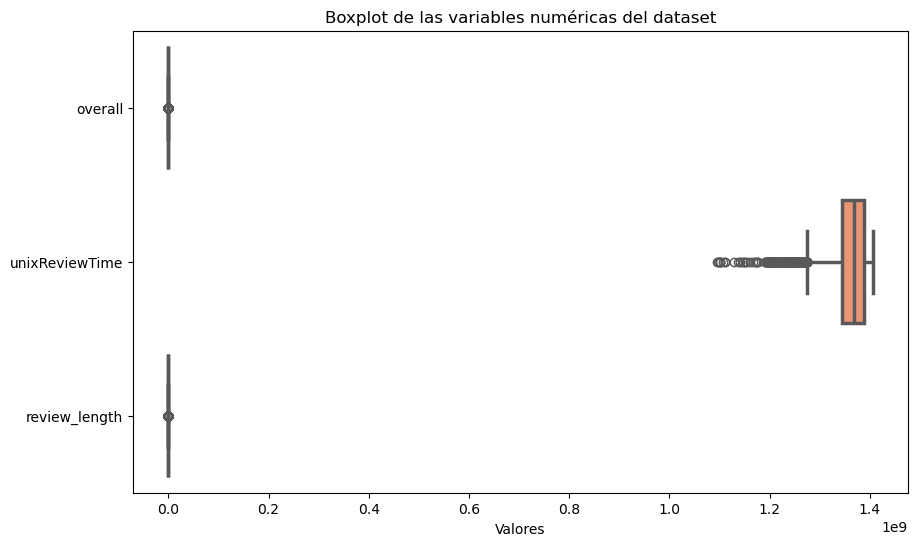

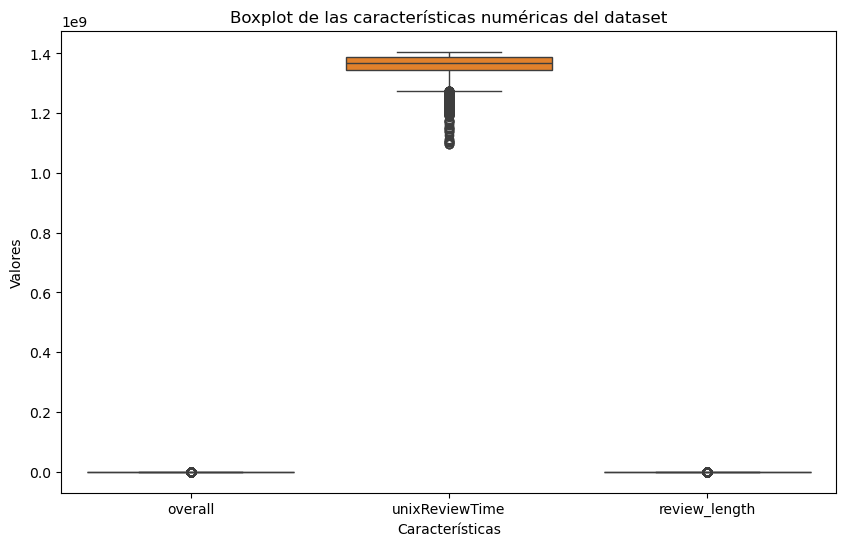

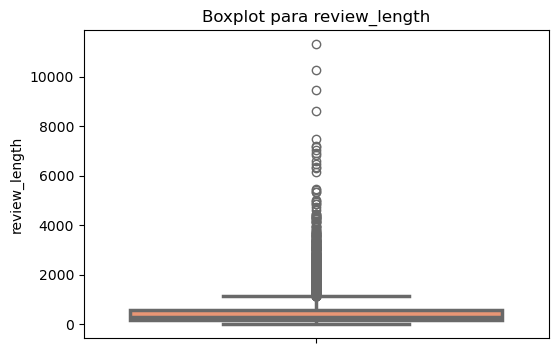

In [139]:
import seaborn as sns
import matplotlib.pyplot as plt

# Supongamos que tu dataset es valoraciones
# Identificamos las columnas numéricas para el análisis
numeric_cols = valoraciones.select_dtypes(include=['number']).columns

# 1. Boxplot para todas las variables numéricas a la vez
plt.figure(figsize=(10, 6))  # Ajusta el tamaño de la figura
sns.boxplot(data=valoraciones[numeric_cols], orient="h", palette="Set2", linewidth=2.5)
plt.title("Boxplot de las variables numéricas del dataset")
plt.xlabel("Valores")
plt.show()

# 2. Boxplot por cada variable numérica en el dataset
plt.figure(figsize=(10, 6))
sns.boxplot(data=valoraciones[numeric_cols])  # Muestra todas las características numéricas
plt.title('Boxplot de las características numéricas del dataset')
plt.xlabel('Características')
plt.ylabel('Valores')
plt.show()

# 3. Boxplot para una variable específica
variable_especifica = 'review_length'  # Cambia a la columna que quieras analizar
plt.figure(figsize=(6, 4))
sns.boxplot(y=variable_especifica, data=valoraciones, color=sns.color_palette("Set2")[1], linewidth=2.5)
plt.title(f"Boxplot para {variable_especifica}")
plt.ylabel(variable_especifica)
plt.show()


## Rango intercuartilico

Outliers encontrados por IQR en posiciones:
 [18, 184, 186, 190, 194, 200, 208, 216, 217, 226, 255, 256, 301, 351, 354, 355, 358, 362, 365, 367, 368, 369, 371, 373, 378, 386, 394, 401, 403, 404, 412, 416, 418, 419, 422, 430, 440, 447, 449, 456, 484, 506, 527, 538, 544, 554, 609, 614, 656, 701, 702, 703, 729, 739, 745, 796, 865, 887, 900, 925, 957, 962, 982, 998, 1060, 1062, 1064, 1067, 1069, 1116, 1122, 1127, 1155, 1201, 1258, 1286, 1358, 1364, 1380, 1402, 1413, 1422, 1424, 1426, 1431, 1455, 1468, 1474, 1483, 1493, 1524, 1531, 1552, 1558, 1560, 1642, 1681, 1707, 1755, 1756, 1780, 1795, 1807, 1809, 1811, 1812, 1815, 1819, 1825, 1826, 1875, 1882, 1883, 1884, 1885, 1887, 1908, 1944, 1947, 1952, 1953, 1957, 1966, 1973, 1975, 1989, 1994, 2004, 2018, 2019, 2020, 2023, 2024, 2028, 2033, 2039, 2068, 2095, 2103, 2112, 2160, 2189, 2191, 2214, 2218, 2263, 2265, 2291, 2296, 2303, 2328, 2369, 2403, 2410, 2443, 2448, 2451, 2535, 2578, 2616, 2617, 2620, 2622, 2624, 2626, 2627, 2649, 2668, 2685, 2689,

C:\Users\Ikasle\AppData\Local\Temp\ipykernel_15728\3906520222.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=valoraciones, y=variable, palette="Set2")


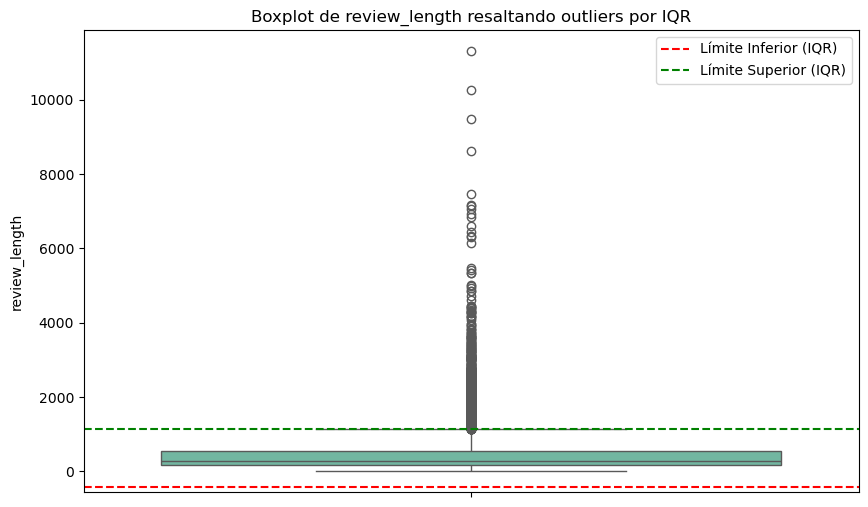

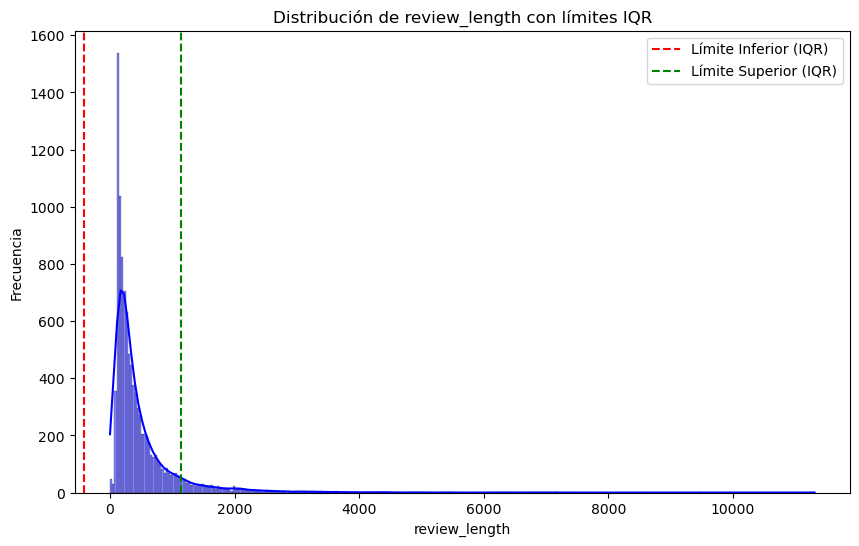

In [156]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

# Supongamos que `valoraciones` es tu dataset y 'review_length' es la variable a analizar
variable = 'review_length'

# Verificar si la columna existe
if variable not in valoraciones.columns:
    raise ValueError(f"La columna {variable} no existe en el dataset.")

# 1 - Rango Intercuartílico (IQR)
IQR = valoraciones[variable].quantile(0.75) - valoraciones[variable].quantile(0.25)
lower_whisker = valoraciones[variable].quantile(0.25) - (1.5 * IQR)
upper_whisker = valoraciones[variable].quantile(0.75) + (1.5 * IQR)

outlier_positions_IQR = [x for x in range(valoraciones.shape[0]) if valoraciones[variable].iloc[x] < lower_whisker or valoraciones[variable].iloc[x] > upper_whisker]

print("Outliers encontrados por IQR en posiciones:\n", outlier_positions_IQR)
print(f"Valores atípicos en {variable}:\n", valoraciones[variable].iloc[outlier_positions_IQR].values)

# Gráfico Boxplot para visualizar los outliers
plt.figure(figsize=(10, 6))
sns.boxplot(data=valoraciones, y=variable, palette="Set2")
plt.title(f'Boxplot de {variable} resaltando outliers por IQR')
plt.axhline(lower_whisker, color='red', linestyle='--', label='Límite Inferior (IQR)')
plt.axhline(upper_whisker, color='green', linestyle='--', label='Límite Superior (IQR)')
plt.legend()
plt.show()

# Gráfico de densidad para observar la distribución
plt.figure(figsize=(10, 6))
sns.histplot(valoraciones[variable], kde=True, color='blue')
plt.axvline(lower_whisker, color='red', linestyle='--', label='Límite Inferior (IQR)')
plt.axvline(upper_whisker, color='green', linestyle='--', label='Límite Superior (IQR)')
plt.title(f'Distribución de {variable} con límites IQR')
plt.xlabel(variable)
plt.ylabel('Frecuencia')
plt.legend()
plt.show()


## Desviación Típica


Outliers encontrados por Desviación Estándar:
 [186, 194, 208, 226, 351, 362, 365, 368, 371, 403, 412, 484, 544, 701, 957, 1155, 1364, 1524, 1558, 1809, 1815, 1883, 1884, 1887, 1966, 1973, 1975, 2018, 2019, 2068, 2095, 2191, 2403, 2649, 2668, 2905, 2921, 2940, 2942, 2963, 3097, 3613, 3758, 3771, 3782, 3880, 4189, 4222, 4254, 4311, 4445, 4454, 4531, 4574, 4653, 4708, 4745, 4906, 4949, 4955, 4982, 5010, 5056, 5118, 5210, 5237, 5244, 5306, 5581, 5593, 5600, 5606, 5630, 5631, 5638, 5707, 5736, 5738, 5813, 5821, 5973, 5984, 6189, 6194, 6385, 6411, 6416, 6417, 6461, 6554, 6576, 6587, 6604, 6612, 6645, 6652, 6654, 6690, 6758, 6917, 6918, 6923, 6928, 6935, 6982, 6996, 7064, 7190, 7201, 7205, 7267, 7287, 7293, 7297, 7405, 7427, 7438, 7483, 7489, 7504, 7556, 7576, 7695, 7699, 7742, 7743, 7873, 7874, 7877, 7922, 8065, 8068, 8084, 8086, 8296, 8424, 8426, 8429, 8475, 8477, 8481, 8484, 8493, 8494, 8500, 8544, 8631, 8632, 8636, 8667, 8710, 8713, 8733, 8782, 8787, 8812, 8931, 8939, 8943, 8956, 9100, 

<Figure size 1000x500 with 0 Axes>

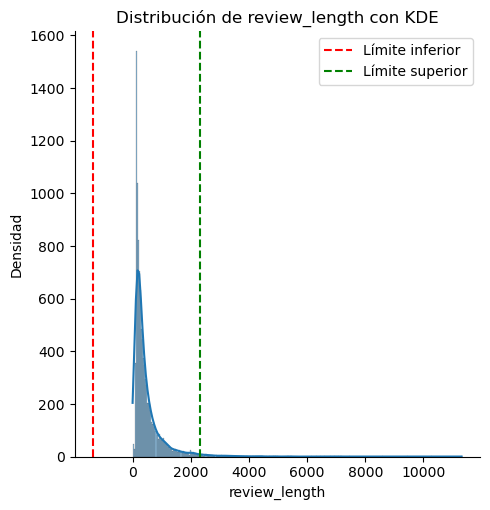

In [157]:
# 2 - Desviación Estándar
media = valoraciones[variable].mean()
desviacion = valoraciones[variable].std()
punto_corte_inferior = media - (3 * desviacion)
punto_corte_superior = media + (3 * desviacion)

outlier_positions_std = [x for x in range(valoraciones.shape[0]) if valoraciones[variable].iloc[x] < punto_corte_inferior or valoraciones[variable].iloc[x] > punto_corte_superior]

print("\nOutliers encontrados por Desviación Estándar:\n", outlier_positions_std)
print(f"Valores atípicos en {variable}:\n", valoraciones[variable].iloc[outlier_positions_std].values)

# Gráfico de densidad para Desviación Estándar
plt.figure(figsize=(10, 5))
sns.displot(valoraciones[variable], kde=True)
plt.title(f'Distribución de {variable} con KDE')
plt.xlabel(variable)
plt.ylabel('Densidad')
plt.axvline(punto_corte_inferior, color='r', linestyle='--', label='Límite inferior')
plt.axvline(punto_corte_superior, color='g', linestyle='--', label='Límite superior')
plt.legend()
plt.show()


## Z-Score 

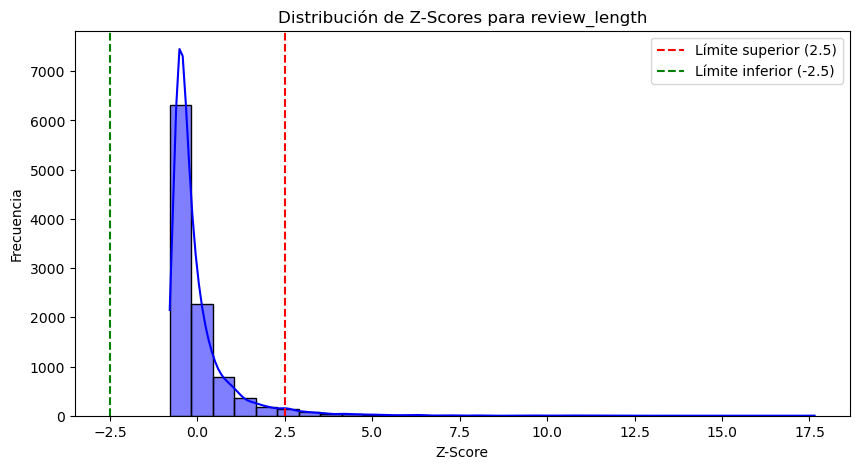


Outliers encontrados con Z-Score usando límite 3:
 [186, 194, 208, 226, 351, 362, 365, 368, 371, 403, 412, 484, 544, 701, 957, 1155, 1364, 1524, 1558, 1809, 1815, 1883, 1884, 1887, 1966, 1973, 1975, 2018, 2019, 2068, 2095, 2191, 2403, 2649, 2668, 2905, 2921, 2940, 2942, 2963, 3097, 3613, 3758, 3771, 3782, 3880, 4189, 4222, 4254, 4311, 4445, 4454, 4531, 4574, 4653, 4708, 4745, 4906, 4949, 4955, 4982, 5010, 5056, 5118, 5210, 5237, 5244, 5306, 5581, 5593, 5600, 5606, 5630, 5631, 5638, 5707, 5736, 5738, 5813, 5821, 5973, 5984, 6189, 6194, 6385, 6411, 6416, 6417, 6461, 6554, 6576, 6587, 6604, 6612, 6645, 6652, 6654, 6690, 6758, 6917, 6918, 6923, 6928, 6935, 6982, 6996, 7064, 7190, 7201, 7205, 7267, 7287, 7293, 7297, 7405, 7427, 7438, 7483, 7489, 7504, 7556, 7576, 7695, 7699, 7742, 7743, 7873, 7874, 7877, 7922, 8065, 8068, 8084, 8086, 8296, 8424, 8426, 8429, 8475, 8477, 8481, 8484, 8493, 8494, 8500, 8544, 8631, 8632, 8636, 8667, 8710, 8713, 8733, 8782, 8787, 8812, 8931, 8939, 8943, 8956, 91

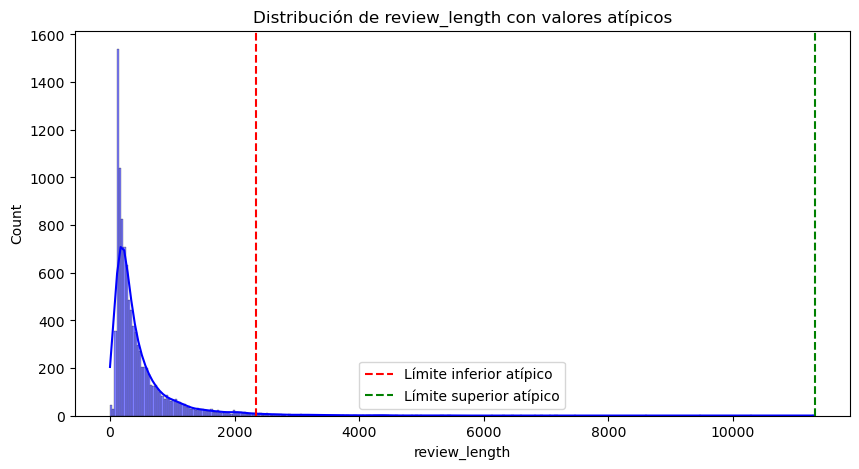

In [158]:
# Calcula los Z-Scores para la variable de interés
z_scores = zscore(valoraciones[variable])

# Visualización de la distribución de Z-Scores
plt.figure(figsize=(10, 5))
sns.histplot(z_scores, kde=True, bins=30, color='blue')
plt.title(f'Distribución de Z-Scores para {variable}')
plt.xlabel('Z-Score')
plt.ylabel('Frecuencia')
plt.axvline(x=2.5, color='r', linestyle='--', label='Límite superior (2.5)')
plt.axvline(x=-2.5, color='g', linestyle='--', label='Límite inferior (-2.5)')
plt.legend()
plt.show()

# Ajustar el límite y volver a calcular outliers
nuevo_limite = 3 # Ajusta aquí tu nuevo límite
outlier_positions_zscore = [x for x in range(valoraciones.shape[0]) if z_scores[x] < -nuevo_limite or z_scores[x] > nuevo_limite]

print(f"\nOutliers encontrados con Z-Score usando límite {nuevo_limite}:\n", outlier_positions_zscore)
print(f"Valores atípicos en {variable}:\n", valoraciones[variable].iloc[outlier_positions_zscore].values)

# Visualizar la distribución con nuevo límite
plt.figure(figsize=(10, 5))
sns.histplot(valoraciones[variable], kde=True, color='blue')
plt.title(f'Distribución de {variable} con valores atípicos')
plt.axvline(valoraciones[variable].iloc[outlier_positions_zscore].min(), color='r', linestyle='--', label='Límite inferior atípico')
plt.axvline(valoraciones[variable].iloc[outlier_positions_zscore].max(), color='g', linestyle='--', label='Límite superior atípico')
plt.legend()
plt.show()


## Reducción de la Dimensionalidad 

## Normalizar y Estandarizar 